## RNN (Recurrent Neural Network)
xi = input (xit..)
yi = output (yit ...)

**UniDirectional RNN**
So it use the previous xi1t, xi2t, xi3t in order to make predictions for yi3t 

**limitation** this is also its limitation because it only use pevious info rather than the next as well
`for example:`
* *He said "Teddy* Roosevelt was a good president"
* *He said "Teddy* Bears are on sale!"

**FeedForward Propogation (left-to-right):**
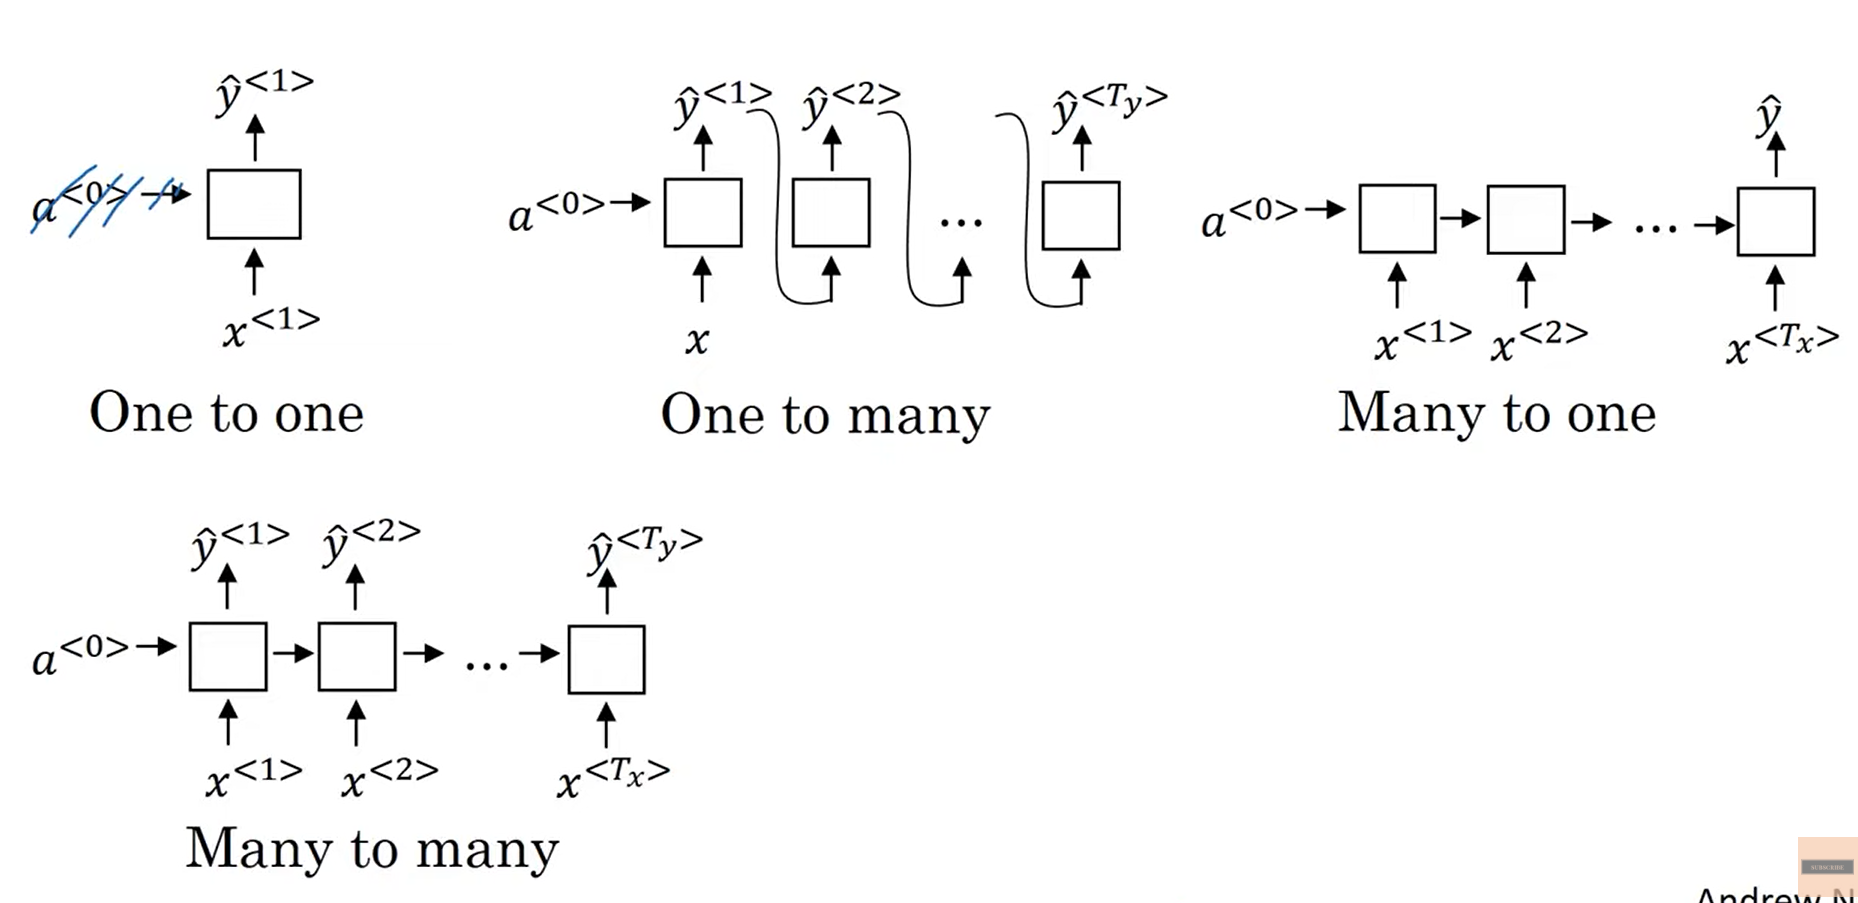


In [4]:
import numpy as np

In [5]:
text = "The central point of the book is that a person's life is determined by agreements\
        they have made with themselves, with others, with God, and with society as a whole.\
        Through these agreements, one determines how they see themselves,\
        what is possible for them, how they should behave, and their worth as a person"

print(text)

The central point of the book is that a person's life is determined by agreements        they have made with themselves, with others, with God, and with society as a whole.        Through these agreements, one determines how they see themselves,        what is possible for them, how they should behave, and their worth as a person


In [6]:
tokens = [word.lower() for word in text.split()]
tokens

['the',
 'central',
 'point',
 'of',
 'the',
 'book',
 'is',
 'that',
 'a',
 "person's",
 'life',
 'is',
 'determined',
 'by',
 'agreements',
 'they',
 'have',
 'made',
 'with',
 'themselves,',
 'with',
 'others,',
 'with',
 'god,',
 'and',
 'with',
 'society',
 'as',
 'a',
 'whole.',
 'through',
 'these',
 'agreements,',
 'one',
 'determines',
 'how',
 'they',
 'see',
 'themselves,',
 'what',
 'is',
 'possible',
 'for',
 'them,',
 'how',
 'they',
 'should',
 'behave,',
 'and',
 'their',
 'worth',
 'as',
 'a',
 'person']

In [7]:
vocab = {w:i for i, w in enumerate(set(tokens))}
n_vocab = len(vocab)
n_vocab

40

In [8]:
def ohe(tokens, vocab):
    e = []
    for token in tokens:
        ohe = np.zeros(len(vocab))
        if token in vocab:
            ohe[vocab[token]] = 1.0
        e.append(ohe)
    return np.array(e)

e = ohe(tokens, vocab)
print(e[2])

[0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [9]:
e.shape

(54, 40)

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [11]:
df = pd.DataFrame(e, columns=vocab.keys(), index=tokens)

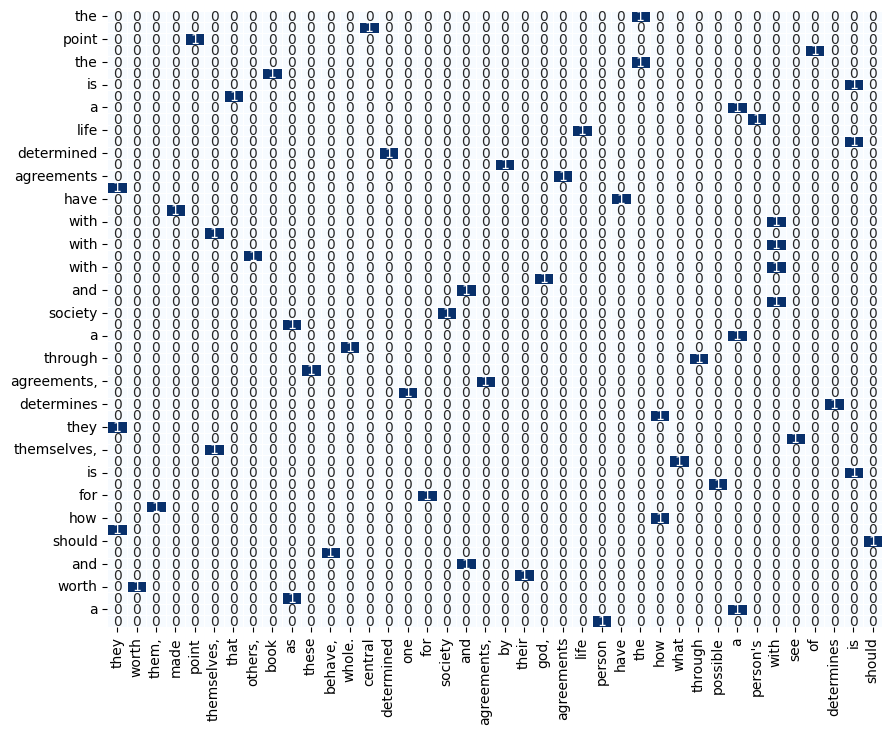

In [12]:
plt.figure(figsize=(10, 8))
sns.heatmap(df, annot=True, cmap='Blues', cbar=False, linewidths=0.5)
plt.show()

In [13]:
## input vector to rnn at each time step (input_t = (54, 1)) one word 
e[:, 0].reshape(-1, 1).shape

(54, 1)

In [14]:
## input output pairs
p = []
for i in range(len(tokens) - 1):
    p.append((e[i], tokens[i + 1]))
i = np.array([pair[0] for pair in p])
t = np.array([pair[1] for pair in p])
print(i[0])

[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]


In [15]:
# ## forward pass
# ## x at time t1 and multiply that with input weight wi -> hidden step 
# ## hidden step -> activation [(add the input + prev hidden step ) x hidden weights ] -> ouput x output weights

# np.random.seed(3)
# wxh = np.random.rand(vocab_size, hidden_size) * 0.01 # weight matrix connecting the input to the hidden layer
# whh = np.random.rand(hidden_size, hidden_size) * 0.01 ## hidden to hidden layer
# bh = np.zeros((hidden_size, 1)) ## bias for the hidden layer

# ## output weights and biases
# why = np.random.rand(vocab_size, hidden_size) * 0.01
# by = np.zeros((vocab_size, 1))


# ## hidden state (zero vector representing the hidden state before any inputs have been processed)
# h_prev = np.zeros((hidden_size, 1)) 


# ## process each time step 
# for input_t, target_t in zip(i, t):
#     input_t = input_t.reshape(-1, 1)
#     h_current = np.tanh(np.dot(wxh, input_t) + np.dot(whh, h_prev) + bh) # current hidden state
#     output_t = np.dot(why, h_current) + by
    
#     h_prev = h_current  # carry forward the hidden state for the next time step
    
#     print(f"Hidden state at time step {t}: {h_current.T}")
    

In [16]:
# def softmax(x):
#     exp_x = np.exp(x - np.max(x))
#     return exp_x / np.sum(exp_x)

# prob = softmax(output_t)
# print(f"probabilities at time step{t}: {prob.T}")

In [17]:
i.shape

(53, 40)

In [18]:
import torch.nn as nn
import torch
import torch.nn.functional as F
from tqdm import tqdm

In [19]:
n_h = 128


In [20]:
class RNN(nn.Module):
    def __init__(self, input, hidden, output):
        super(RNN, self).__init__()
        self.hidden = hidden
        self.i2h = nn.Linear(input, hidden)
        self.h2h = nn.Linear(hidden, hidden)
        self.h2o = nn.Linear(hidden, output)
        self.activation = nn.LogSoftmax(dim=1)

    def forward(self, i, h):
        h = F.tanh(self.i2h(i) + self.h2h(h))
        output = self.h2o(h)
        output = self.activation (output)
        return output, h
    def initHidden(self):
        return torch.zeros(1, self.hidden)
        

In [21]:
rnn = RNN(n_vocab, n_h, n_vocab)

In [22]:
c = nn.NLLLoss() ## negative log likelihood
optimizer = torch.optim.SGD(rnn.parameters(), lr=0.001)

## training
for epoch in range(1000):
    hidden = rnn.initHidden()
    for k in range(len(i)):
        i_tensor = torch.tensor(i[k], dtype=torch.float32).view(1, -1)
        t_tensor = torch.tensor([vocab[t[k]]]) ## target index
        optimizer.zero_grad() ## zero gradients
        o, h = rnn(i_tensor, hidden)
        loss = c(o, t_tensor)
        loss.backward()
        optimizer.step() ## updating weights
    if epoch % 100 == 0:  # Print every 100 epochs
        print(f'Epoch: {epoch}, Loss: {loss.item()}')  

Epoch: 0, Loss: 3.6856584548950195
Epoch: 100, Loss: 3.7056772708892822
Epoch: 200, Loss: 3.6944870948791504
Epoch: 300, Loss: 3.5997731685638428
Epoch: 400, Loss: 3.430246353149414
Epoch: 500, Loss: 3.1953322887420654
Epoch: 600, Loss: 2.900834083557129
Epoch: 700, Loss: 2.566530227661133
Epoch: 800, Loss: 2.2320821285247803
Epoch: 900, Loss: 1.9416009187698364


In [24]:
## rnn are not good at handling long-term dependencies

In [75]:
start_word = 'agreements'
gen_seq = [start_word]
n = 3

hidden = rnn.initHidden()
current_word = torch.tensor(ohe([start_word], vocab), dtype=torch.float32)

for _ in range(n):
    o, h = rnn(current_word.view(1, -1), hidden)
    pred = o.argmax(dim=1).item()
    pred_word = list(vocab.keys())[list(vocab.values()).index(pred)]
    gen_seq.append(pred_word)
    current_word = torch.tensor(ohe([pred_word], vocab), dtype=torch.float32)

print(' '.join(gen_seq))
    

agreements they see themselves,
